# Remake patches with padding

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorlayer as tl
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage
import skimage.morphology
from skimage.measure import label   
import math
import pandas as pd
import re
from pathlib import Path
import imageio
import scipy as sp
import shutil
import glob2
from tqdm import tqdm
import os
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


## Define Processing Fuctions

In [2]:
def cropBorders(img, l=0.01, r=0.01, u=0.04, d=0.04):
    nrows, ncols = img.shape
    # Get the start and end rows and columns
    l_crop = int(ncols * l)
    r_crop = int(ncols * (1 - r))
    u_crop = int(nrows * u)
    d_crop = int(nrows * (1 - d))
    cropped_img = img[u_crop:d_crop, l_crop:r_crop]
    return cropped_img

def minMaxNormalise(img):
    norm_img = (img - img.min()) / (img.max() - img.min())
    return norm_img

def globalBinarise(img, thresh, maxval):
    binarised_img = np.zeros(img.shape, np.uint8)
    binarised_img[img >= thresh] = maxval
    return binarised_img

def editMask(mask, ksize=(23, 23), operation="open"):
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=ksize)
    if operation == "open":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    elif operation == "close":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # Then dilate
    edited_mask = cv2.morphologyEx(edited_mask, cv2.MORPH_DILATE, kernel)
    return edited_mask

def sortContoursByArea(contours, reverse=True):
    # Sort contours based on contour area.
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=reverse)
    # Construct the list of corresponding bounding boxes.
    bounding_boxes = [cv2.boundingRect(c) for c in sorted_contours]
    return sorted_contours, bounding_boxes

def xLargestBlobs(mask, top_x=None, reverse=True):
    # Find all contours from binarised image.
    # Note: parts of the image that you want to get should be white.
    contours, hierarchy = cv2.findContours(
        image=mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE
    )
    n_contours = len(contours)
    # Only get largest blob if there is at least 1 contour.
    if n_contours > 0:
        # Make sure that the number of contours to keep is at most equal
        # to the number of contours present in the mask.
        if n_contours < top_x or top_x == None:
            top_x = n_contours
        # Sort contours based on contour area.
        sorted_contours, bounding_boxes = sortContoursByArea(
            contours=contours, reverse=reverse
        )
        # Get the top X largest contours.
        X_largest_contours = sorted_contours[0:top_x]
        # Create black canvas to draw contours on.
        to_draw_on = np.zeros(mask.shape, np.uint8)
        # Draw contours in X_largest_contours.
        X_largest_blobs = cv2.drawContours(
            image=to_draw_on,  # Draw the contours on `to_draw_on`.
            contours=X_largest_contours,  # List of contours to draw.
            contourIdx=-1,  # Draw all contours in `contours`.
            color=1,  # Draw the contours in white.
            thickness=-1,  # Thickness of the contour lines.
        )
    return n_contours, X_largest_blobs

def applyMask(img, mask):
    masked_img = img.copy()
    masked_img[mask == 0] = 0
    return masked_img

def checkLRFlip(mask):
    # Get number of rows and columns in the image.
    nrows, ncols = mask.shape
    x_center = ncols // 2
    y_center = nrows // 2
    # Sum down each column.
    col_sum = mask.sum(axis=0)
    # Sum across each row.
    row_sum = mask.sum(axis=1)
    left_sum = sum(col_sum[0:x_center])
    right_sum = sum(col_sum[x_center:-1])
    if left_sum < right_sum:
        LR_flip = True
    else:
        LR_flip = False
    return LR_flip


def makeLRFlip(img):
    flipped_img = np.fliplr(img)
    return flipped_img

def clahe(img, clip=2.0, tile=(8, 8)):
    img = cv2.normalize(
        img,
        None,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )
    img_uint8 = img.astype("uint8")
    clahe_create = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    clahe_img = clahe_create.apply(img_uint8)
    return clahe_img

def pad(img):
    nrows, ncols = img.shape
    # If padding is required...
    if nrows != ncols:
        # Take the longer side as the target shape.
        if ncols < nrows:
            target_shape = (nrows, nrows)
        elif nrows < ncols:
            target_shape = (ncols, ncols)
        # pad.
        padded_img = np.zeros(shape=target_shape)
        padded_img[:nrows, :ncols] = img
    # If padding is not required...
    elif nrows == ncols:
        # Return original image.
        padded_img = img
    return padded_img

def display_images(display_list,titles,ncol=3):
    plt.figure(figsize=(15,15))
    nrow = int(np.ceil(len(display_list)/ncol))
    
    for i in range(len(display_list)):
        plt.subplot(nrow,ncol,i+1)
        plt.title(titles[i])
        plt.imshow(display_list[i],cmap='gray')
    plt.show()

In [3]:
def fullMammoPreprocess(
    img,
    l,
    r,
    d,
    u,
    thresh,
    maxval,
    ksize,
    operation,
    reverse,
    top_x,
    clip,
    tile,
):

    # Step 1: Initial crop.
    cropped_img = cropBorders(img=img, l=l, r=r, d=d, u=u)

    # Step 2: Min-max normalise.
    norm_img = minMaxNormalise(img=cropped_img)

    # Step 3: Remove artefacts.
    binarised_img = globalBinarise(img=norm_img, thresh=thresh, maxval=maxval)
    edited_mask = editMask(
        mask=binarised_img, ksize=(ksize, ksize), operation=operation
    )
    _, xlargest_mask = xLargestBlobs(mask=edited_mask, top_x=top_x, reverse=reverse)

    masked_img = applyMask(img=norm_img, mask=xlargest_mask)

    # Step 4: Horizontal flip.
    lr_flip = checkLRFlip(mask=xlargest_mask)
    if lr_flip:
        flipped_img = makeLRFlip(img=masked_img)
    elif not lr_flip:
        flipped_img = masked_img

    # Step 5: CLAHE enhancement.
    clahe_img = clahe(img=flipped_img, clip=clip, tile=(tile, tile))

    # Step 6: pad.
    padded_img = pad(img=clahe_img)
    padded_img = cv2.normalize(
        padded_img,
        None,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )

    # Step 7: Min-max normalise.
    img_pre = minMaxNormalise(img=padded_img)

    return img_pre, lr_flip

def maskPreprocess(mask, lr_flip):

    # Step 1: Initial crop.
    mask = cropBorders(img=mask)

    # Step 2: Horizontal flip.
    if lr_flip:
        mask = makeLRFlip(img=mask)

    # Step 3: Pad.
    mask_pre = pad(img=mask)

    return mask_pre

def sumMasks(mask_list):

    summed_mask = np.zeros(mask_list[0].shape)

    for arr in mask_list:
        summed_mask = np.add(summed_mask, arr)

    # Binarise (there might be some overlap, resulting in pixels with
    # values of 510, 765, etc...)
    _, summed_mask_bw = cv2.threshold(
        src=summed_mask, thresh=1, maxval=255, type=cv2.THRESH_BINARY
    )

    return summed_mask_bw


In [4]:
l = 0.01
r = 0.01
u = 0.04
d = 0.04
thresh = 0.1
maxval = 1.0
ksize = 23
operation = "open"
reverse = True
top_x = 1
clip = 2.0
tile = 8

## Process the images

### Calc Training

In [5]:
input_topdir = '/home/alangenb_mit_edu/tensorflow_datasets/downloads/manual/'
output_topdir = '/home/alangenb_mit_edu/tensorflow_datasets/downloads/new-patch/train/'
df = pd.read_csv('/home/alangenb_mit_edu/manifests/calc_case_description_train_set.csv')

In [6]:
df["samp_prefix"] = [re.sub(r'\/.*','',x) for x in df["image file path"].tolist()]
df["input_img_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x) for x in df["image file path"].tolist()]
df["input_patch_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x).rstrip() for x in df["ROI mask file path"].tolist()]
df["input_mask_path"] = [input_topdir + re.sub(r'\.dcm.*','.png',x).rstrip() for x in df["cropped image file path"].tolist()]
df["patch_prefix"] = [re.sub(r'\/','-',re.sub(r'.*_.\/|\/[01]+\.png.*','',x)) for x in df["input_patch_path"].tolist()]
df["type"] = [re.sub(r'_WITHOUT_CALLBACK','',x)+"_CALCIFICATION" for x in df["pathology"].tolist()]
unitype = np.unique(df["type"].tolist())
outdirs = [output_topdir + x + "/" for x in unitype]
for j in range(len(outdirs)):
    if not os.path.exists(outdirs[j]):
        os.mkdir(outdirs[j])
df["output_patch_path"] = [output_topdir+df["type"].tolist()[x]+"/"+df["patch_prefix"].tolist()[x]+"-abnorm_"+
                           str(df["abnormality id"].tolist()[x])+".png" for x in np.arange(df.shape[0])]

In [7]:
for i in tqdm(range(df.shape[0])):
    image = imageio.imread(df["input_img_path"].tolist()[i])
    mask = imageio.imread(df["input_mask_path"].tolist()[i])
    roi = imageio.imread(re.sub(r'1.png','0.png',df["input_mask_path"].tolist()[i]))
    if np.median(mask)>0:
        tmp = mask
        mask = roi
        roi = tmp
    rows,cols = np.where(mask>0)
    xmin = min(rows); xmax = max(rows); ymin = min(cols); ymax = max(cols)
    input_patch = image[xmin:xmax,ymin:ymax]
    xdiff = xmax-xmin; ydiff = ymax-ymin
    xpad = int(np.ceil(xdiff/2)); ypad = int(np.ceil(ydiff/2))
    
    if xmin-xpad<0:
        xmin = 0; xmax = min(2*xdiff,image.shape[0])
    elif xmax+xpad>image.shape[0]:
        xmax = image.shape[0]; xmin = max(xmax-2*xdiff,0)
    else:
        xmin = xmin-xpad; xmax = xmax+xpad
    
    if ymin-ypad<0:
        ymin = 0; ymax = min(2*ydiff,image.shape[1])
    elif ymax+ypad>image.shape[1]:
        ymax = image.shape[1]; ymin = max(ymax-2*ydiff,0)
    else:
        ymin = ymin-ypad; ymax = ymax+ypad
        
    output_patch = image[xmin:xmax,ymin:ymax]
    
    imageio.imwrite(df["output_patch_path"].tolist()[i],output_patch)

100%|██████████| 1546/1546 [25:37<00:00,  1.01it/s] 


### Calc Test

In [8]:
input_topdir = '/home/alangenb_mit_edu/tensorflow_datasets/downloads/manual/'
output_topdir = '/home/alangenb_mit_edu/tensorflow_datasets/downloads/new-patch/test/'
df = pd.read_csv('/home/alangenb_mit_edu/manifests/calc_case_description_test_set.csv')

In [9]:
df["samp_prefix"] = [re.sub(r'\/.*','',x) for x in df["image file path"].tolist()]
df["input_img_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x) for x in df["image file path"].tolist()]
df["input_patch_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x).rstrip() for x in df["ROI mask file path"].tolist()]
df["input_mask_path"] = [input_topdir + re.sub(r'\.dcm.*','.png',x).rstrip() for x in df["cropped image file path"].tolist()]
df["patch_prefix"] = [re.sub(r'\/','-',re.sub(r'.*_.\/|\/[01]+\.png.*','',x)) for x in df["input_patch_path"].tolist()]
df["type"] = [re.sub(r'_WITHOUT_CALLBACK','',x)+"_CALCIFICATION" for x in df["pathology"].tolist()]
unitype = np.unique(df["type"].tolist())
outdirs = [output_topdir + x + "/" for x in unitype]
for j in range(len(outdirs)):
    if not os.path.exists(outdirs[j]):
        os.mkdir(outdirs[j])
df["output_patch_path"] = [output_topdir+df["type"].tolist()[x]+"/"+df["patch_prefix"].tolist()[x]+"-abnorm_"+
                           str(df["abnormality id"].tolist()[x])+".png" for x in np.arange(df.shape[0])]

print("all ouput names unique = "+str((len(df["output_patch_path"].tolist())==len(np.unique(df["output_patch_path"].tolist())))
                                &all(~np.array([Path(x).is_file() for x in df["output_patch_path"].tolist()]))))

all ouput names unique = True


In [10]:
for i in tqdm(range(df.shape[0])):
    image = imageio.imread(df["input_img_path"].tolist()[i])
    mask = imageio.imread(df["input_mask_path"].tolist()[i])
    roi = imageio.imread(re.sub(r'1.png','0.png',df["input_mask_path"].tolist()[i]))
    if np.median(mask)>0:
        tmp = mask
        mask = roi
        roi = tmp
    rows,cols = np.where(mask>0)
    xmin = min(rows); xmax = max(rows); ymin = min(cols); ymax = max(cols)
    input_patch = image[xmin:xmax,ymin:ymax]
    xdiff = xmax-xmin; ydiff = ymax-ymin
    xpad = int(np.ceil(xdiff/2)); ypad = int(np.ceil(ydiff/2))
    
    if xmin-xpad<0:
        xmin = 0; xmax = min(2*xdiff,image.shape[0])
    elif xmax+xpad>image.shape[0]:
        xmax = image.shape[0]; xmin = max(xmax-2*xdiff,0)
    else:
        xmin = xmin-xpad; xmax = xmax+xpad
    
    if ymin-ypad<0:
        ymin = 0; ymax = min(2*ydiff,image.shape[1])
    elif ymax+ypad>image.shape[1]:
        ymax = image.shape[1]; ymin = max(ymax-2*ydiff,0)
    else:
        ymin = ymin-ypad; ymax = ymax+ypad
        
    output_patch = image[xmin:xmax,ymin:ymax]
    
    imageio.imwrite(df["output_patch_path"].tolist()[i],output_patch)

100%|██████████| 326/326 [04:31<00:00,  1.20it/s]


### Mass Train

In [111]:
input_topdir = '/home/alangenb_mit_edu/tensorflow_datasets/downloads/manual/'
output_topdir = '/home/alangenb_mit_edu/tensorflow_datasets/downloads/new-patch/train/'
df = pd.read_csv('/home/alangenb_mit_edu/manifests/mass_case_description_train_set.csv')

In [112]:
df["samp_prefix"] = [re.sub(r'\/.*','',x) for x in df["image file path"].tolist()]
df["input_img_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x) for x in df["image file path"].tolist()]
df["input_patch_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x).rstrip() for x in df["ROI mask file path"].tolist()]
df["input_mask_path"] = [input_topdir + re.sub(r'\.dcm.*','.png',x).rstrip() for x in df["cropped image file path"].tolist()]
df["patch_prefix"] = [re.sub(r'\/','-',re.sub(r'.*_.\/|\/[01]+\.png.*','',x)) for x in df["input_patch_path"].tolist()]
df["type"] = [re.sub(r'_WITHOUT_CALLBACK','',x)+"_MASS" for x in df["pathology"].tolist()]
unitype = np.unique(df["type"].tolist())
outdirs = [output_topdir + x + "/" for x in unitype]
for j in range(len(outdirs)):
    if not os.path.exists(outdirs[j]):
        os.mkdir(outdirs[j])
df["output_patch_path"] = [output_topdir+df["type"].tolist()[x]+"/"+df["patch_prefix"].tolist()[x]+"-abnorm_"+
                           str(df["abnormality id"].tolist()[x])+".png" for x in np.arange(df.shape[0])]
last_idx = np.array([int(re.sub(r'\.dcm','',x).rstrip()[-1]) for x in df["ROI mask file path"].tolist()])
df = df.iloc[np.where(last_idx==1)[0],:]

print("all ouput names unique = "+str((len(df["output_patch_path"].tolist())==len(np.unique(df["output_patch_path"].tolist())))
                                &all(~np.array([Path(x).is_file() for x in df["output_patch_path"].tolist()]))))

all ouput names unique = False


In [114]:
for i in tqdm(range(df.shape[0])):
    image = imageio.imread(df["input_img_path"].tolist()[i])
    mask = imageio.imread(df["input_mask_path"].tolist()[i])
    roi = imageio.imread(re.sub(r'0.png','1.png',df["input_mask_path"].tolist()[i]))
    if np.median(mask)>0:
        tmp = mask
        mask = roi
        roi = tmp
    rows,cols = np.where(mask>0)
    xmin = min(rows); xmax = max(rows); ymin = min(cols); ymax = max(cols)
    input_patch = image[xmin:xmax,ymin:ymax]
    xdiff = xmax-xmin; ydiff = ymax-ymin
    xpad = int(np.ceil(xdiff/2)); ypad = int(np.ceil(ydiff/2))
    
    if xmin-xpad<0:
        xmin = 0; xmax = min(2*xdiff,image.shape[0])
    elif xmax+xpad>image.shape[0]:
        xmax = image.shape[0]; xmin = max(xmax-2*xdiff,0)
    else:
        xmin = xmin-xpad; xmax = xmax+xpad
    
    if ymin-ypad<0:
        ymin = 0; ymax = min(2*ydiff,image.shape[1])
    elif ymax+ypad>image.shape[1]:
        ymax = image.shape[1]; ymin = max(ymax-2*ydiff,0)
    else:
        ymin = ymin-ypad; ymax = ymax+ypad
        
    output_patch = image[xmin:xmax,ymin:ymax]
    
    imageio.imwrite(df["output_patch_path"].tolist()[i],output_patch)

100%|██████████| 1226/1226 [10:44<00:00,  1.90it/s]


### Mass test

In [115]:
input_topdir = '/home/alangenb_mit_edu/tensorflow_datasets/downloads/manual/'
output_topdir = '/home/alangenb_mit_edu/tensorflow_datasets/downloads/new-patch/test/'
df = pd.read_csv('/home/alangenb_mit_edu/manifests/mass_case_description_test_set.csv')

In [116]:
df["samp_prefix"] = [re.sub(r'\/.*','',x) for x in df["image file path"].tolist()]
df["input_img_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x) for x in df["image file path"].tolist()]
df["input_patch_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x).rstrip() for x in df["ROI mask file path"].tolist()]
df["input_mask_path"] = [input_topdir + re.sub(r'\.dcm.*','.png',x).rstrip() for x in df["cropped image file path"].tolist()]
df["patch_prefix"] = [re.sub(r'\/','-',re.sub(r'.*_.\/|\/[01]+\.png.*','',x)) for x in df["input_patch_path"].tolist()]
df["type"] = [re.sub(r'_WITHOUT_CALLBACK','',x)+"_MASS" for x in df["pathology"].tolist()]
unitype = np.unique(df["type"].tolist())
outdirs = [output_topdir + x + "/" for x in unitype]
for j in range(len(outdirs)):
    if not os.path.exists(outdirs[j]):
        os.mkdir(outdirs[j])
df["output_patch_path"] = [output_topdir+df["type"].tolist()[x]+"/"+df["patch_prefix"].tolist()[x]+"-abnorm_"+
                           str(df["abnormality id"].tolist()[x])+".png" for x in np.arange(df.shape[0])]
last_idx = np.array([int(re.sub(r'\.dcm','',x).rstrip()[-1]) for x in df["ROI mask file path"].tolist()])
df = df.iloc[np.where(last_idx==1)[0],:]

print("all ouput names unique = "+str((len(df["output_patch_path"].tolist())==len(np.unique(df["output_patch_path"].tolist())))
                                &all(~np.array([Path(x).is_file() for x in df["output_patch_path"].tolist()]))))

all ouput names unique = True


In [127]:
for i in tqdm(range(df.shape[0])):
    image = imageio.imread(df["input_img_path"].tolist()[i])
    mask = imageio.imread(df["input_mask_path"].tolist()[i])
    roi = imageio.imread(re.sub(r'0.png','1.png',df["input_mask_path"].tolist()[i]))
    if np.median(mask)>0:
        tmp = mask
        mask = roi
        roi = tmp
    rows,cols = np.where(mask>0)
    xmin = min(rows); xmax = max(rows); ymin = min(cols); ymax = max(cols)
    input_patch = image[xmin:xmax,ymin:ymax]
    xdiff = xmax-xmin; ydiff = ymax-ymin
    xpad = int(np.ceil(xdiff/2)); ypad = int(np.ceil(ydiff/2))
    
    if xmin-xpad<0:
        xmin = 0; xmax = min(2*xdiff,image.shape[0])
    elif xmax+xpad>image.shape[0]:
        xmax = image.shape[0]; xmin = max(xmax-2*xdiff,0)
    else:
        xmin = xmin-xpad; xmax = xmax+xpad
    
    if ymin-ypad<0:
        ymin = 0; ymax = min(2*ydiff,image.shape[1])
    elif ymax+ypad>image.shape[1]:
        ymax = image.shape[1]; ymin = max(ymax-2*ydiff,0)
    else:
        ymin = ymin-ypad; ymax = ymax+ypad
        
    output_patch = image[xmin:xmax,ymin:ymax]
    
    imageio.imwrite(df["output_patch_path"].tolist()[i],output_patch)

 27%|██▋       | 99/367 [00:50<02:15,  1.98it/s]


KeyboardInterrupt: 

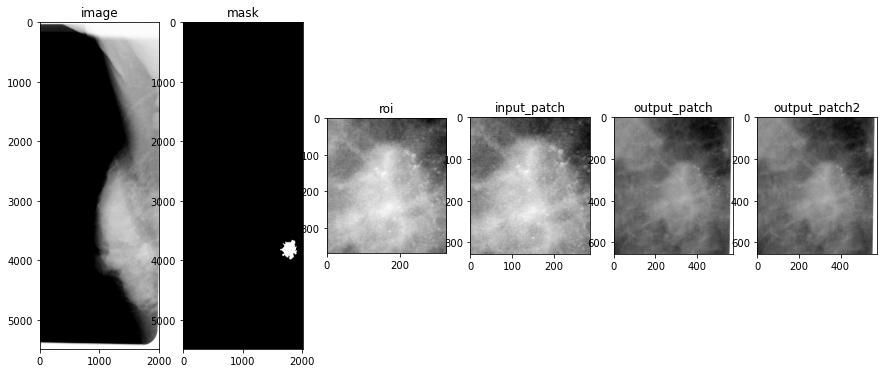

In [124]:
    #i = np.random.choice(df.shape[0],size=1)[0]
    i = 1
    image = imageio.imread(df["input_img_path"].tolist()[i])
    files = glob2.glob(input_topdir+df["samp_prefix"].tolist()[i]+"_"+str(df["abnormality id"].tolist()[i])+"/**/*png")
    mask = imageio.imread(files[0])
    roi = imageio.imread(files[1])
    if np.median(mask)>0:
        tmp = mask
        mask = roi
        roi = tmp
    rows,cols = np.where(mask>0)
    xmin = min(rows); xmax = max(rows); ymin = min(cols); ymax = max(cols)
    input_patch = image[xmin:xmax,ymin:ymax]
    xdiff = xmax-xmin; ydiff = ymax-ymin
    xpad = int(np.ceil(xdiff/2)); ypad = int(np.ceil(ydiff/2))
    
    if xmin-xpad<0:
        xmin = 0; xmax = min(2*xdiff,image.shape[0])
    elif xmax+xpad>image.shape[0]:
        xmax = image.shape[0]; xmin = max(xmax-2*xdiff,0)
    else:
        xmin = xmin-xpad; xmax = xmax+xpad
    
    if ymin-ypad<0:
        ymin = 0; ymax = min(2*ydiff,image.shape[1])
    elif ymax+ypad>image.shape[1]:
        ymax = image.shape[1]; ymin = max(ymax-2*ydiff,0)
    else:
        ymin = ymin-ypad; ymax = ymax+ypad
        
    output_patch = image[xmin:xmax,ymin:ymax]
    output_patch2 = imageio.imread(df["output_patch_path"].tolist()[i])
    #output_patch2 = output_patch
    
    display_images([image,mask,roi,input_patch,output_patch,output_patch2],
                   ['image','mask','roi','input_patch','output_patch','output_patch2'],ncol=6)

In [126]:
np.min(output_patch2)

135

In [85]:
df.iloc[i+2,:]

patient_id                                                           P_00061
breast_density                                                             2
left or right breast                                                   RIGHT
image view                                                                CC
abnormality id                                                             1
abnormality type                                                        mass
mass shape                                                         LOBULATED
mass margins                                                   CIRCUMSCRIBED
assessment                                                                 3
pathology                                                             BENIGN
subtlety                                                                   4
image file path            Mass-Training_P_00061_RIGHT_CC/1.3.6.1.4.1.959...
cropped image file path    Mass-Training_P_00061_RIGHT_CC_1/1.3.6.1.4.1.9...

In [43]:
np.array(df["input_patch_path"].tolist())[(i-5):(i+5)]

array(['/home/alangenb_mit_edu/tensorflow_datasets/downloads/manual/Calc-Training_P_01767_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.270722198212632664505371030281092441303/1.3.6.1.4.1.9590.100.1.2.331885647812413853023991013521986389483/000001.png',
       '/home/alangenb_mit_edu/tensorflow_datasets/downloads/manual/Calc-Training_P_01769_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.164743507011850305517872835943121018354/1.3.6.1.4.1.9590.100.1.2.11923459413577584828234211130421576740/000001.png',
       '/home/alangenb_mit_edu/tensorflow_datasets/downloads/manual/Calc-Training_P_01769_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.230836032512404332717509228824285574962/1.3.6.1.4.1.9590.100.1.2.54835282911909360437657509594097375670/000001.png',
       '/home/alangenb_mit_edu/tensorflow_datasets/downloads/manual/Calc-Training_P_01769_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.167736386612488663700014445230198072949/1.3.6.1.4.1.9590.100.1.2.380314661112994145730422846802952564850/000001.png',
       '/home/alangenb_mit_